## Diffusion Model for FastMRI - Sample Mean/Variance

Code to use a trained DDPM for generating new brain MR images of different contrasts, then computing mean and pixel-wise variance of the images.

In [1]:
from tqdm import tqdm
from datetime import datetime
import os

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

from fastmri_brain_data_builder import get_labels_key
from unet import real_to_complex, complex_to_real, ContextUnet, BigContextUnet
from ddpm import DDPM

from skimage.metrics import peak_signal_noise_ratio
import imageio

device = torch.device("cuda")

### Load the model

In [2]:
save_dir = './cond_ddpm_models/May05_0847_mag'
chkpoint= 850

complex_in = False
n_T = 500
img_shape = (160, 160)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#%%
labels_key = get_labels_key('../LSS/lss_jcb/aniket/FastMRI brain data/')
num_classes = len(labels_key)
weights_fname = f'/ddpm_ep{chkpoint}.pth'

eps_model = BigContextUnet(complex_in=complex_in, n_classes=4)

ddpm = DDPM(eps_model=eps_model, betas=(1e-4, 0.02), n_T=n_T, complex_in=complex_in, device=device)
ddpm.to(device)

ddpm.load_state_dict(torch.load(save_dir + weights_fname))
print("Num params:", count_parameters(ddpm))

Num params: 61723137


### Generate many samples

In [3]:
n_samples = 5

ddpm.eval()
with torch.no_grad():
    out_samples_list = ddpm.sample_compare(n_samples, (1, img_shape[-2], img_shape[-1]))

[Sample 5 of 5]: 100%|██████████| 500/500 [01:39<00:00,  5.00it/s]


### Plot samples

In [4]:
print("Sample shape:", out_samples_list.shape)

Sample shape: (4, 5, 160, 160)


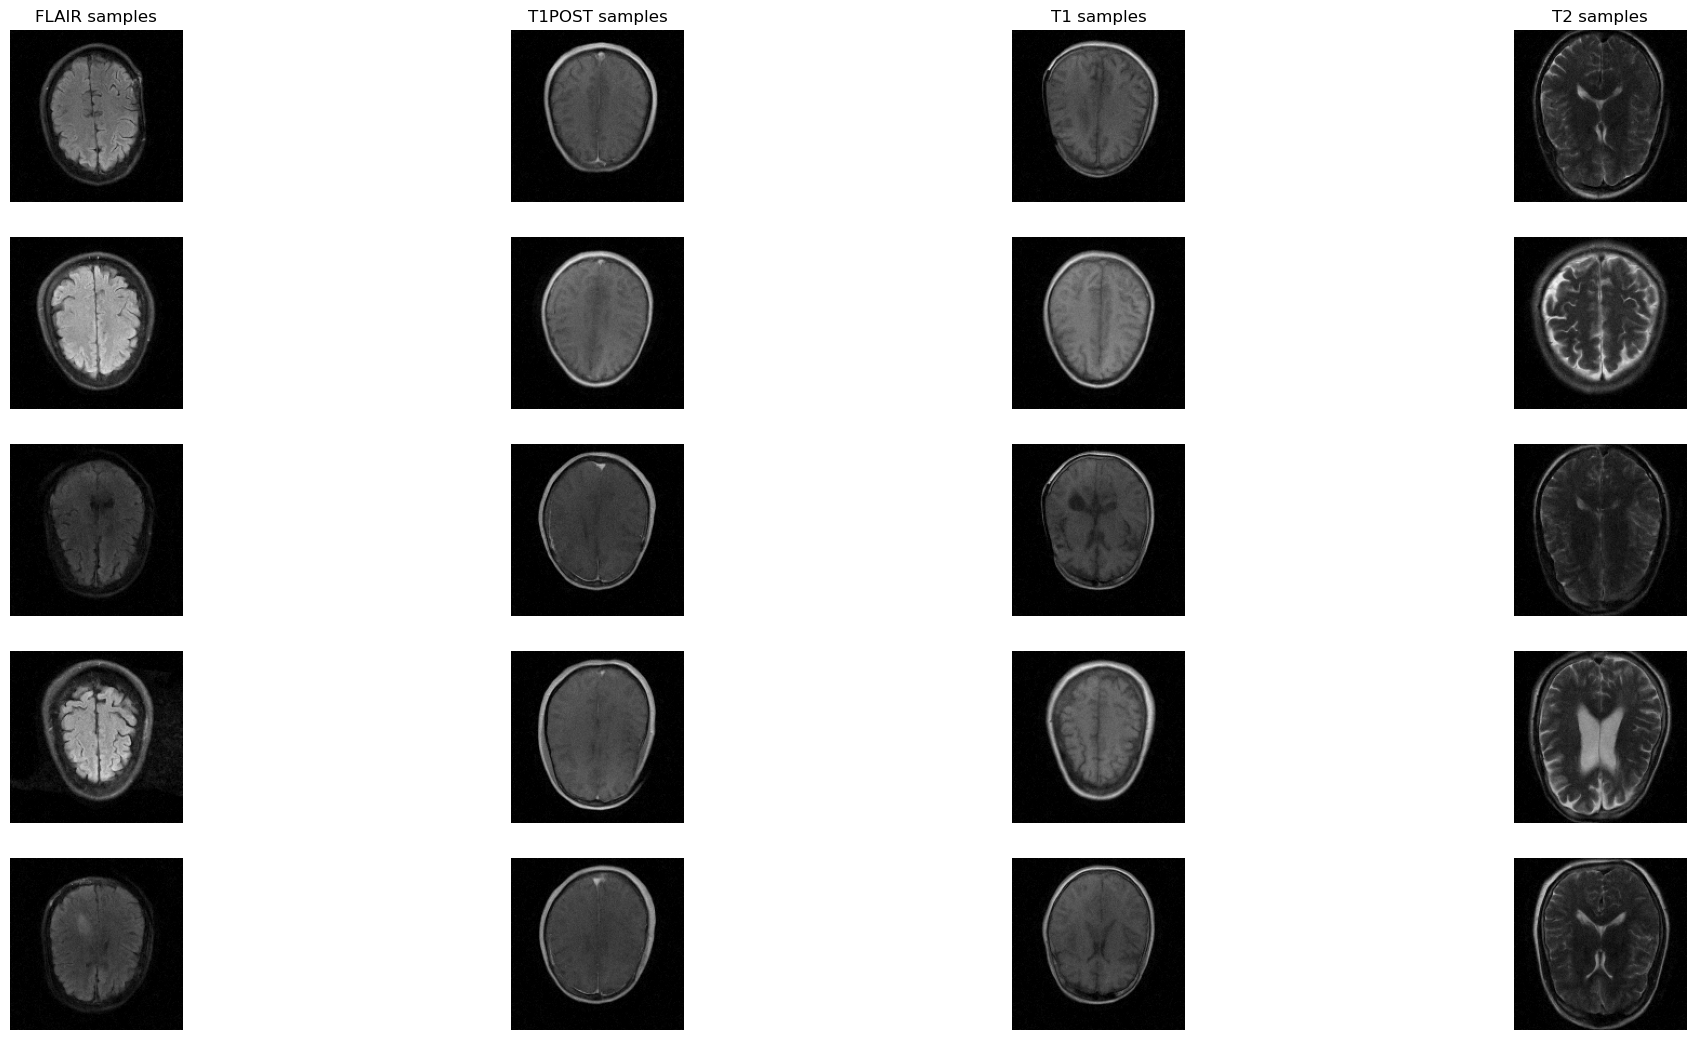

In [5]:
fig, ax = plt.subplots(n_samples, num_classes, figsize=(20,10))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.01)

for i in range(n_samples):
    for j in range(num_classes):
        img = out_samples_list[j, i]
        ax[i,j].imshow(img, cmap='gray', vmin=0., vmax=1.)
        ax[i,j].axis('off')
        if i==0: ax[i,j].set_title(f'{labels_key[j]} samples')
plt.savefig('samples_grid.png')
plt.show()

### Plot mean images

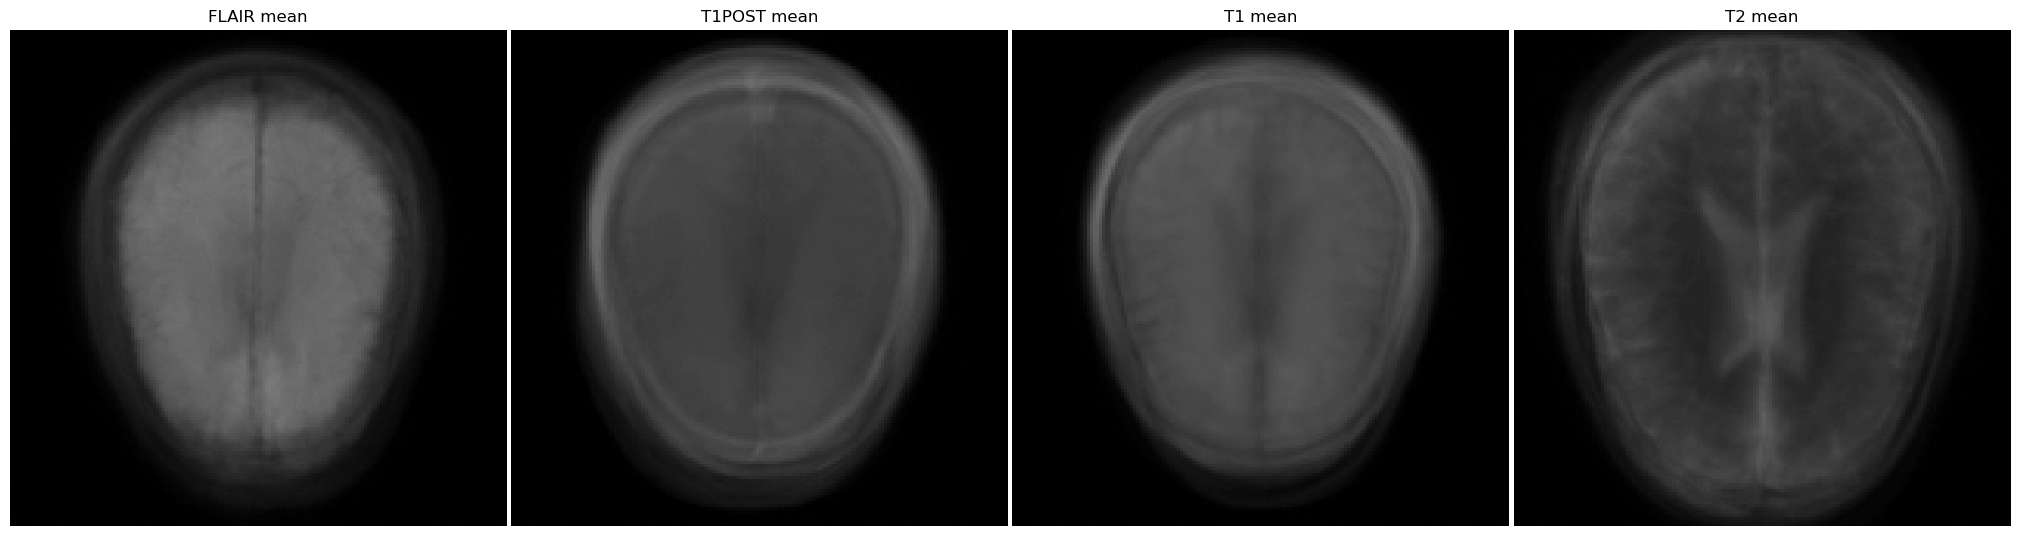

In [6]:
fig, ax = plt.subplots(1, num_classes, figsize=(20,10))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.01)

mean_imgs = np.mean(out_samples_list, axis=1)

for i in range(num_classes):
    img = mean_imgs[i]
    ax[i].imshow(img, cmap='gray', vmin=0., vmax=1.)
    ax[i].axis('off')
    ax[i].set_title(f'{labels_key[i]} mean')
plt.savefig('samples_mean.png')
plt.show()

### Plot variance

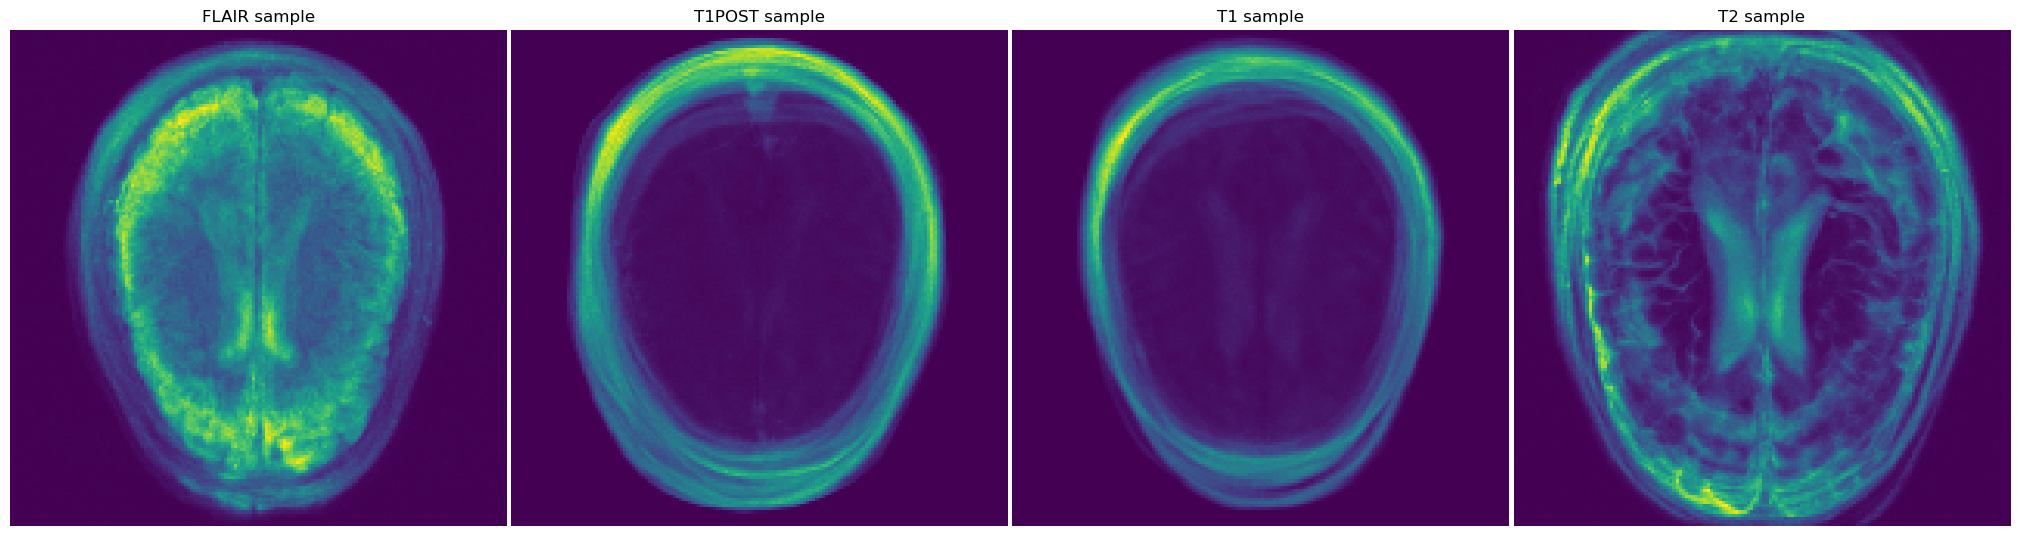

In [7]:
fig, ax = plt.subplots(1, num_classes, figsize=(20,10))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.01)

var_imgs = np.var(out_samples_list, axis=1)

for i in range(num_classes):
    img = var_imgs[i]
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(f'{labels_key[i]} sample')
plt.savefig('samples_var.png')
plt.show()